### 🤖 Implement ReAct with LangGraph-What is ReAct?
ReAct (Reasoning + Acting) is a framework where an LLM:

- Reasons step-by-step (e.g. decomposes questions, makes decisions)

- Acts by calling tools like search, calculators, or retrievers

This makes it perfect for Agentic RAG:
✅ Think → Retrieve → Observe → Reflect → Final Answer

In [2]:
import os
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import Tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END
from langgraph.graph import StateGraph
from typing import Annotated, TypedDict, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph.message import add_messages

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
# --------------------------
# 1. Create Retriever Tool
# --------------------------

# Load content from blog
docs = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [4]:
retriever.invoke("what are autonomous agents")

[Document(id='d8aa131b-78bf-4f10-9fae-a0838216a5c7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [5]:
def retriever_tool_func(query: str) -> str:
    print("📚 Using RAGRetriever tool")
    docs = retriever.invoke(query)
    return "\n".join([doc.page_content for doc in docs])

In [6]:
retriever_tool_func("what are autonomous agents")

📚 Using RAGRetriever tool


'Citation#\nCited as:\n\nWeng, Lilian. (Jun 2023). “LLM-powered Autonomous Agents”. Lil’Log. https://lilianweng.github.io/posts/2023-06-23-agent/.\nBoiko et al. (2023) also looked into LLM-empowered agents for scientific discovery, to handle autonomous design, planning, and performance of complex scientific experiments. This agent can use tools to browse the Internet, read documentation, execute code, call robotics experimentation APIs and leverage other LLMs.\nFor example, when requested to "develop a novel anticancer drug", the model came up with the following reasoning steps:\nOr\n@article{weng2023agent,\n  title   = "LLM-powered Autonomous Agents",\n  author  = "Weng, Lilian",\n  journal = "lilianweng.github.io",\n  year    = "2023",\n  month   = "Jun",\n  url     = "https://lilianweng.github.io/posts/2023-06-23-agent/"\n}\nReferences#\n[1] Wei et al. “Chain of thought prompting elicits reasoning in large language models.” NeurIPS 2022\n[2] Yao et al. “Tree of Thoughts: Dliberate P

In [10]:
retriever_tool=Tool(
    name="RAGRetriever",
    description="Use this tool to fetch relevant knowledge base info",
    func=retriever_tool_func
)
retriever_tool
print(retriever_tool.name)

RAGRetriever


In [7]:
# Wikipedia tool
wiki_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
wiki_tool

WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\Welcome\\OneDrive\\Documents\\AI\\AgenticAi\\venv\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=3, lang='en', load_all_available_meta=False, doc_content_chars_max=4000))

In [8]:
import os
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
llm=init_chat_model("openai:gpt-4o")

C:\Users\Welcome\AppData\Local\Temp\ipykernel_7364\329661528.py:10: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(llm,tools)


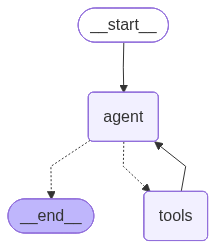

In [11]:
# ----------------------------
# 2. Define the Agent Node
# ----------------------------



tools = [retriever_tool, wiki_tool]

## create the native Langgraph react agent
react_node=create_react_agent(llm,tools)
react_node

In [12]:
# --------------------------
# 3. LangGraph Agent State
# --------------------------

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

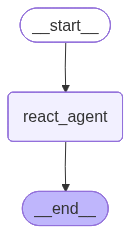

In [13]:
# --------------------------
# 4. Build LangGraph Graph
# --------------------------

builder = StateGraph(AgentState)

builder.add_node("react_agent", react_node)
builder.set_entry_point("react_agent")
builder.add_edge("react_agent", END)

graph = builder.compile()
graph

In [14]:
# --------------------------
# 5. Run the ReAct Agent
# --------------------------

if __name__ == "__main__":
    user_query = "What is an agent loop and how does Wikipedia describe autonomous agents?"
    state = {"messages": [HumanMessage(content=user_query)]}
    result = graph.invoke(state)

    print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using RAGRetriever tool

✅ Final Answer:
 An "agent loop" concept involves the interaction and learning process in AI agents where a model iteratively improves its actions based on performance feedback, as part of reinforcement learning (RL). This idea emphasizes using a learning history to predict more effective actions in subsequent iterations. The goal is to enhance the RL process rather than develop a task-specific policy. LLM-empowered agents demonstrate this concept by autonomously conducting complex tasks like scientific experiments, leveraging internet browsing, reading documentation, and executing code for improved performance and decision-making.

### Autonomous Agents (Wikipedia Summary)
An autonomous agent in artificial intelligence is a system capable of performing complex tasks independently. It encompasses intelligent agents as entities that perceive environments, act autonomously to achieve goals, and may enhance performance through machine learning. Intelligent agent

### Tool creation for RAG agents with langgraph 
To create tools for RAG agents using LangGraph, you're essentially building LLM-invocable functions that your agent can call as part of its reasoning + acting loop (ReAct).

LangGraph uses the Tool abstraction from LangChain and fully supports tools for:

- RAG retrieval
- Search
- Wikipedia
- SQL
- Web APIs
- Calculators, etc.

#### ✅ Tool Design Requirements
A LangGraph tool must:

- Have a name
- Have a description (used by the LLM to decide when to use it)
- Have a callable func, accepting a single input (usually str) and returning str

In [15]:
import os
from typing import Annotated, Sequence, TypedDict
from langchain_core.tools import Tool
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader, ArxivLoader, TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain.agents import create_agent
from langgraph.graph import StateGraph, END
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph.message import add_messages

In [16]:
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000001F8FFF35AF0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000001F8FFF36ED0>, root_client=<openai.OpenAI object at 0x000001F88B5AB5C0>, root_async_client=<openai.AsyncOpenAI object at 0x000001F8FFF34680>, model_name='gpt-4o', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [18]:
### Generic function to create a retrieval tool
def make_retriever_tool_from_text(file, name, desc):
    docs = TextLoader(file, encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query: str) -> str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name, description=desc, func=tool_func)


# Wikipedia Tool (already a tool, don't wrap in Tool())
api_wrapper = WikipediaAPIWrapper()
wiki_tool = WikipediaQueryRun(api_wrapper=api_wrapper)

# ArXiv Tool
def arxiv_search(query: str) -> str:
    print("🧪 Searching ArXiv...")
    results = ArxivLoader(query).load()
    return "\n\n".join(doc.page_content[:1000] for doc in results[:2]) or "No papers found."

arxiv_tool = Tool(
    name="ArxivSearch",
    description="Use this tool to fetch recent academic papers on technical topics.",
    func=arxiv_search
)

In [20]:
internal_tool_1=make_retriever_tool_from_text(
    "sample_docs.txt",
    "InternalTechDocs",
    "Search internal tech documents for proprietary architecture and methods."
)
internal_tool_1

Tool(name='InternalTechDocs', description='Search internal tech documents for proprietary architecture and methods.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x000001F8C60C4680>)

In [21]:
internal_tool_2 = make_retriever_tool_from_text(
    "research_notes.txt",
    "InternalResearchNotes",
    "Search internal research notes for experimental results and agent designs."
)
internal_tool_2

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results and agent designs.', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x000001F8FFDE3C40>)

C:\Users\Welcome\AppData\Local\Temp\ipykernel_7364\1687477868.py:3: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  react_node=create_react_agent(llm,tools)


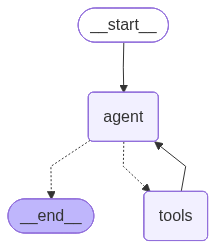

In [22]:
tools=[wiki_tool,arxiv_tool,internal_tool_1,internal_tool_2]

react_node=create_react_agent(llm,tools)
react_node

In [23]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

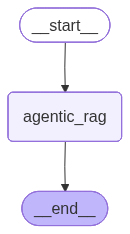

In [24]:
builder = StateGraph(AgentState)
builder.add_node("agentic_rag", react_node)
builder.set_entry_point("agentic_rag")
builder.add_edge("agentic_rag", END)

graph = builder.compile()
graph


In [25]:
query = "What do our internal research notes say about transformer variants, and what does ArXiv suggest recently?"

state = {"messages": [HumanMessage(content=query)]}
result = graph.invoke(state)

print("\n✅ Final Answer:\n", result["messages"][-1].content)

📚 Using tool: InternalResearchNotes
🧪 Searching ArXiv...

✅ Final Answer:
 ### Internal Research Notes on Transformer Variants

Here's a summary of our recent experiments and findings related to transformer variants:

1. **EfficientFormer**:
   - Achieved a top-1 accuracy of 92.4% on TinyImageNet.
   - Peak memory usage is 290MB with a batch size of 16.
   - Target deployment is on Raspberry Pi 4.
   - Works efficiently in quantized int8 mode with no significant accuracy drop.

2. **Longformer**:
   - Evaluated on customer support logs with a maximum token limit of 8192.
   - Latency exceeds 1.2 seconds per query in a streaming setting.
   - Chunk-based hybrid attention might reduce latency delays.

3. **Reformer**:
   - Experienced challenges such as bucket collisions and inconsistent loss spikes beyond 5k steps during training.
   - Encountered sparse gradient updates during LSH attention.
   - Solutions attempted included gradient clipping, warmup scheduler, and memory-efficient att